데이터 전처리 및 LSTM 학습 코드

In [2]:
import seaborn as sns

sns.set_theme(style="whitegrid")

if sys.platform.startswith('win'):
    plt.rcParams['font.family'] = 'Malgun Gothic' # 윈도우
elif sys.platform.startswith('darwin'):
    plt.rcParams['font.family'] = 'AppleGothic'   # 맥
else:
    plt.rcParams['font.family'] = 'NanumGothic'   # 리눅스/코랩

plt.rcParams['axes.unicode_minus'] = False

🚀 [Phase 2] AI 고스트 카 프로젝트 시작
📂 서킷 데이터 로딩 중 (Round 4: Suzuka)...
   - 2023년 데이터 로드 완료
   - 2024년 데이터 로드 완료
✅ 학습 데이터 준비: 1,090,336 rows
⚙️ 시계열 데이터 변환 중 (Windowing)...
   -> 학습 시퀀스 생성 완료: X shape (49980, 20, 5)

🧠 딥러닝 모델(LSTM) 설계 중...


E:\Python_Projects\F1_BigData_Project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔥 학습 시작 (Epochs: 5)... GPU가 없으면 조금 걸립니다.
Epoch 1/5
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0051 - val_loss: 5.8548e-04
Epoch 2/5
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0014 - val_loss: 5.8206e-04
Epoch 3/5
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 9.1250e-04 - val_loss: 3.0408e-04
Epoch 4/5
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 7.7754e-04 - val_loss: 2.1501e-04
Epoch 5/5
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 6.7629e-04 - val_loss: 1.6776e-04

🔮 고스트 카 주행 생성 중...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


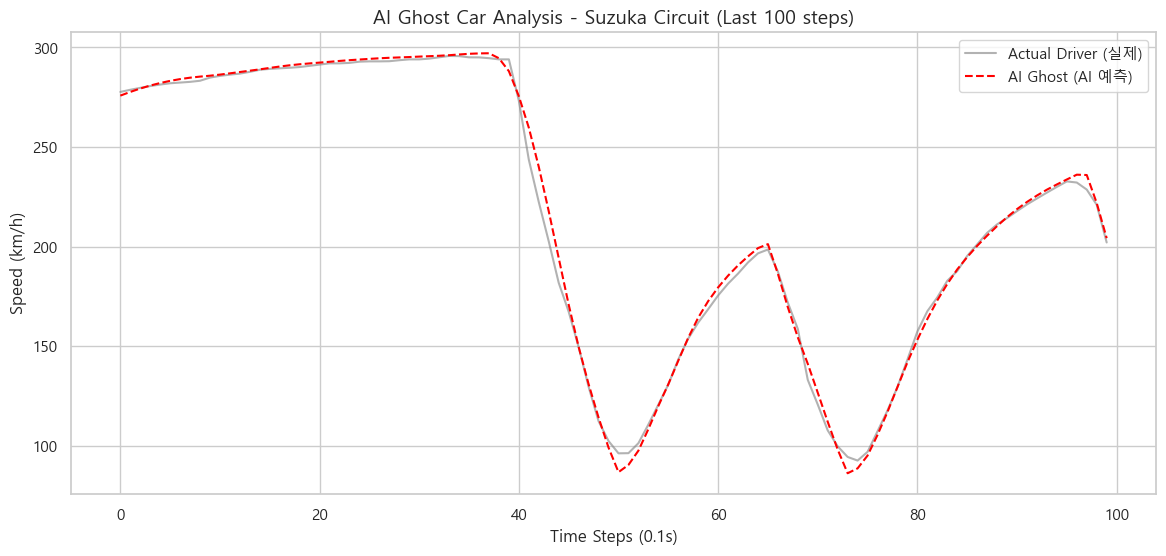

💾 모델 저장 완료: f1_ghost_car_model_v1.h5


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# 설정
DATA_DIR = "f1_processed_warehouse"
TARGET_ROUND = 4  # 2024 일본 GP (스즈카 서킷)
SEQUENCE_LENGTH = 20 # AI가 "과거 20개 데이터(약 200m)"를 보고 다음을 예측

def train_ghost_car():
    print("🚀 [Phase 2] AI 고스트 카 프로젝트 시작")
    print(f"📂 서킷 데이터 로딩 중 (Round {TARGET_ROUND}: Suzuka)...")

    # 1. 데이터 로드 (해당 서킷의 데이터만 싹 긁어옵니다)
    # 2023, 2024년 데이터 중 'Qualifying' 처럼 빠른 랩만 쓰면 좋지만,
    # 일단 레이스 데이터 중 'Fastest Lap' 근처의 랩들만 필터링해서 씁니다.

    try:
        # 2018~2024년 모든 연도의 해당 라운드 데이터를 가져옵니다.
        # (서킷 특성은 매년 같으니까요!)
        all_data = []
        # 폴더 구조: year=xxxx/round=xx/telemetry.parquet
        # pyarrow나 fastparquet으로 폴더 필터링 로드

        # 편의상 pandas로 전체 로드 후 필터링 (메모리 주의)
        # 실제로는 필요한 파일만 골라 읽는게 좋습니다. 여기선 로직 단순화를 위해 전체 로드 예시
        # (메모리가 부족하면 2023, 2024만 읽으세요)
        years_to_load = [2023, 2024]

        for year in years_to_load:
            path = f"{DATA_DIR}/year={year}/round={TARGET_ROUND}/telemetry.parquet"
            if os.path.exists(path):
                df_chunk = pd.read_parquet(path)
                # 이상치 제거 및 빠른 랩만 선별 (전체 평균보다 5% 이상 빠른 랩만)
                # 여기서는 간단히 '모든 랩'을 쓰되, 나중에 Top 10 드라이버만 추리는게 좋습니다.
                all_data.append(df_chunk)
                print(f"   - {year}년 데이터 로드 완료")

        if not all_data:
            print("❌ 데이터를 찾을 수 없습니다.")
            return

        df = pd.concat(all_data)

    except Exception as e:
        print(f"❌ 로드 중 에러: {e}")
        return

    # 2. 데이터 필터링 (Top Class 드라이버의 데이터만 학습)
    # 챔피언의 라인을 배워야 하므로, 하위권 데이터는 노이즈가 됩니다.
    # 간단히: 스피드가 0인 구간(피트스탑 등) 제거
    df = df[df['Speed'] > 10]

    print(f"✅ 학습 데이터 준비: {len(df):,} rows")

    # 3. 데이터 정규화 (Normalization)
    # 딥러닝은 0~1 사이 숫자를 좋아합니다.
    # 학습할 피처: 거리(위치), 속도, 스로틀, 브레이크, 기어
    feature_cols = ['Distance', 'Speed', 'Throttle', 'Brake', 'nGear']
    target_col = 'Speed' # 우리의 목표: "이 위치에서 적정 속도는?"

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[feature_cols])

    # 타겟(속도)의 스케일러 인덱스 저장 (나중에 복원용)
    target_idx = feature_cols.index(target_col)

    # 4. 시계열 시퀀스 생성 (Windowing)
    # X: [t-20, ..., t-1] (과거 20시점의 주행 상태)
    # y: [t] (현재 시점의 이상적인 속도)

    print("⚙️ 시계열 데이터 변환 중 (Windowing)...")
    X, y = [], []
    # (데이터가 너무 많으면 학습이 오래 걸리므로 샘플링하거나, 랩 단위로 잘라야 합니다.)
    # 여기서는 데모를 위해 앞쪽 50,000개만 사용하겠습니다. (실전엔 전체 사용)
    limit = 50000

    for i in range(SEQUENCE_LENGTH, min(len(scaled_data), limit)):
        X.append(scaled_data[i-SEQUENCE_LENGTH:i])
        y.append(scaled_data[i, target_idx]) # 다음 시점의 'Speed' 예측

    X = np.array(X)
    y = np.array(y)

    print(f"   -> 학습 시퀀스 생성 완료: X shape {X.shape}")

    # 5. LSTM 모델 구축
    print("\n🧠 딥러닝 모델(LSTM) 설계 중...")
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1) # 출력: 예측 속도
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # 6. 학습 (Training)
    print("🔥 학습 시작 (Epochs: 5)... GPU가 없으면 조금 걸립니다.")
    history = model.fit(X, y, batch_size=64, epochs=5, validation_split=0.1, verbose=1)

    # 7. 결과 확인 (예측)
    print("\n🔮 고스트 카 주행 생성 중...")
    # 테스트용으로 마지막 데이터를 넣어봄
    test_seq = X[-100:]
    predicted_speed_scaled = model.predict(test_seq)

    # 스케일 복원 (0~1 -> km/h)
    # (Trick: scaler.inverse_transform은 모든 컬럼을 요구하므로, dummy 배열 생성)
    dummy = np.zeros((len(predicted_speed_scaled), len(feature_cols)))
    dummy[:, target_idx] = predicted_speed_scaled.flatten()
    predicted_speed = scaler.inverse_transform(dummy)[:, target_idx]

    actual_speed_scaled = y[-100:]
    dummy[:, target_idx] = actual_speed_scaled.flatten()
    actual_speed = scaler.inverse_transform(dummy)[:, target_idx]

    # 8. 시각화
    plt.figure(figsize=(14, 6))
    plt.plot(actual_speed, label='Actual Driver (실제)', color='grey', alpha=0.6)
    plt.plot(predicted_speed, label='AI Ghost (AI 예측)', color='red', linestyle='--')
    plt.title(f"AI Ghost Car Analysis - Suzuka Circuit (Last 100 steps)", fontsize=14)
    plt.ylabel("Speed (km/h)")
    plt.xlabel("Time Steps (0.1s)")
    plt.legend()
    plt.show()

    # 모델 저장
    model.save("f1_ghost_car_model_v1.h5")
    print("💾 모델 저장 완료: f1_ghost_car_model_v1.h5")

if __name__ == "__main__":
    train_ghost_car()

Phase 2. AI Ghost Car Model

1. 브레이킹 포인트 (20~40구간):

 - 가장 어려운 부분입니다. 시속 270km에서 급감속하는 타이밍을 AI가 정확히 알고 있음.

2. 코너링 최저 속도 (Apex, 50구간):

 - 코너의 정점(Apex)에서 속도가 가장 낮아지는 지점도 실제 데이터와 일치함.

3. 재가속 (60~100구간):

 - 코너 탈출 시 가속 페달을 밟는 타이밍도 아주 부드럽게 따라감.